In [1]:
from refactor import GNNAD

c:\Users\n10907700\Anaconda3\envs\gdn_old\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = GNNAD(shuffle_train=False)
fitted_model = model.fit()

epoch (0 / 100) (Loss:0.80658589, ACU_loss:2.41975766)
epoch (1 / 100) (Loss:0.70174988, ACU_loss:2.10524964)
epoch (2 / 100) (Loss:0.63414681, ACU_loss:1.90244043)
epoch (3 / 100) (Loss:0.56905279, ACU_loss:1.70715836)
epoch (4 / 100) (Loss:0.50592784, ACU_loss:1.51778352)
epoch (5 / 100) (Loss:0.44875027, ACU_loss:1.34625080)
epoch (6 / 100) (Loss:0.40624077, ACU_loss:1.21872231)
epoch (7 / 100) (Loss:0.36984242, ACU_loss:1.10952726)
epoch (8 / 100) (Loss:0.34269124, ACU_loss:1.02807373)
epoch (9 / 100) (Loss:0.31346307, ACU_loss:0.94038922)
epoch (10 / 100) (Loss:0.30232523, ACU_loss:0.90697569)
epoch (11 / 100) (Loss:0.29082531, ACU_loss:0.87247594)
epoch (12 / 100) (Loss:0.27879331, ACU_loss:0.83637993)
epoch (13 / 100) (Loss:0.26880477, ACU_loss:0.80641432)
epoch (14 / 100) (Loss:0.25651600, ACU_loss:0.76954800)
epoch (15 / 100) (Loss:0.25274762, ACU_loss:0.75824286)
epoch (16 / 100) (Loss:0.24726863, ACU_loss:0.74180590)
epoch (17 / 100) (Loss:0.24475727, ACU_loss:0.73427182)
ep

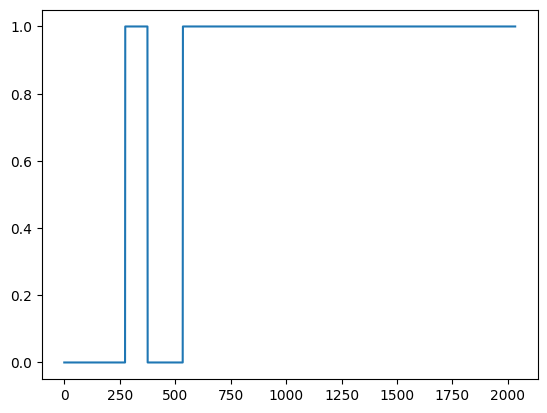

In [3]:
import numpy as np
import matplotlib.pyplot as plt

test_labels = fitted_model.test_result[2, :, 0].tolist()
plt.plot(np.array(test_labels));

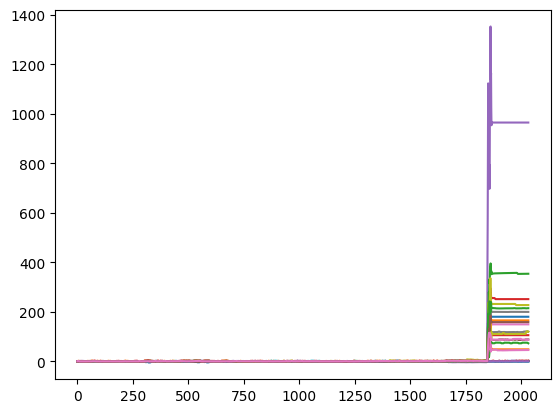

In [4]:
from refactor import get_full_err_scores, eval_scores

test_scores = get_full_err_scores(fitted_model.test_result)
plt.plot(test_scores.T);

In [5]:
total_err_scores = test_scores
gt_labels = test_labels
topk=1


total_features = total_err_scores.shape[0]

# finds topk feature idx of max scores for each time point
topk_indices = np.argpartition(
    total_err_scores, range(total_features - topk - 1, total_features), axis=0
)[-topk:]

# for each time, sum the topk error scores
total_topk_err_scores = np.sum(
    np.take_along_axis(total_err_scores, topk_indices, axis=0), axis=0
)

final_topk_fmeas, thresolds = eval_scores(
    total_topk_err_scores, gt_labels, return_thresold=True
) # scores, true_scores



In [6]:
final_topk_fmeas

[0.8805723720418271,
 0.8817856158721411,
 0.8830022075055188,
 0.8842221608179055,
 0.8848920863309352,
 0.8855638681075091,
 0.8862375138734739,
 0.8869130313976105,
 0.8870339454646634,
 0.88659793814433,
 0.88671875,
 0.8862810841017044,
 0.8860901203470473,
 0.8862107623318386,
 0.8863317429132753,
 0.8870151770657673,
 0.8871376301716858,
 0.8866967305524238,
 0.8868190798758114,
 0.8863764838892029,
 0.8870648174356071,
 0.8866213151927438,
 0.8850411581038887,
 0.8845935190449119,
 0.8843963553530753,
 0.8833761049329911,
 0.8817818389491718,
 0.8807549327995424,
 0.8797250859106529,
 0.8786922856323488,
 0.877656519241815,
 0.8760425654299683,
 0.8755760368663594,
 0.8751081626766658,
 0.873483535528596,
 0.8741683540642176,
 0.8733700376702405,
 0.8723157283807312,
 0.8718395815170009,
 0.8707799767171129,
 0.870300204022151,
 0.8686514886164624,
 0.8681672025723473,
 0.867096018735363,
 0.8660216945177367,
 0.8649442160892542,
 0.8632755072037636,
 0.8621908127208481,
 0.861

In [12]:
len(thresolds)

400

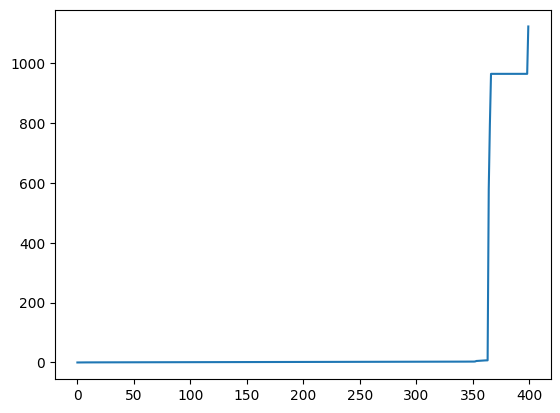

In [10]:
plt.plot(np.array(thresolds))

In [ ]:
plt.plot(topk_indices[0], 'o');

In [ ]:
plt.plot(np.array(test_labels))

In [ ]:
!python main.py -dataset msl -device cpu